## Simulation of Murdock and Okada (1970)
We start by comparing how our prototype- and instance-based implementations of CMR account for behavior in a classic experiment where each item is presented just once per study phase. For these simulations, we used the dataset reported by @murdock1970interresponse. Each of 72 undergraduates performed 20 trials with study lists each consisting of 20 unique words visually presented at either 60 or 120 words per minute. Given a particular subject, words were unique both within and across trials, and randomly selected from the Toronto Word Pool [@friendly1982toronto], a widely-used collection of high frequency nouns, adjectives, and verbs.

While the major focus of the original report by @murdock1970interresponse was to investigate inter-response times in single-trial free recall, here we focus consideration on the content of recorded recall sequences. Because it excludes within-list repetitions of studied items, this dataset presents the opportunity to compare model performance under simplified conditions. Since items' feature representations are assumed orthogonal under considered variants of CMR, retrieving a pattern of contextual associations given an item-based cue only requires abstraction over the cued item's pre-experimental and single experimental contextual associations. Interpretation of apparent differences in performance across model variants thus focus primarily on mechanisms for context-based item representation retrieval.

In [5]:
#| code-summary: code -- load dependencies and data

from compmemlearn.fitting import murdock_objective_function, apply_and_concatenate
from compmemlearn.models import Classic_CMR
from compmemlearn.models import Trace_Reinstatement_CMR
from compmemlearn.datasets import prepare_murdock1970_data, simulate_data
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

murd_trials0, murd_events0, murd_length0 = prepare_murdock1970_data('../../../data/mo1970.txt')

We compared the original prototype-based implementation of CMR against our novel instance-based implementation. First we evaluated each model variant based on their ability to predict the specific sequences of recalls exhibited by each participant. Considering all 20 trials performed by each participant in the dataset, we applied the differential evolution optimization technique to find for each model the parameter configuration that maximized the likelihood of recorded recall sequences. We obtained a unique optimal parameter configuration for each unique participant and each considered model variant. To measure the goodness-of-fit for each parameter configuration and corresponding model, [Figure @fig-MurdOkaFits] plots the log-likelihood of each participant's recall sequences given each model variant's corresponding optimized parameter configuration. The distribution of log-likelihood scores between participants for the PrototypeCMR and InstanceCMR model variants only marginally differ, suggesting little meaningful difference between variants in their effectiveness accounting for participant recall performance across the dataset.

In [3]:
#| output: false
#| code-summary: code -- 1) fit PrototypeCMR participant-by-participant

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

subject_trial_count = 20 # Each subject gets 20 trials/lists a piece.
cmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = murdock_objective_function(
        List([murd_trials0[start_index:start_index+subject_trial_count]]), 
        List([murd_length0]),
        init_cmr,
        {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
        cmr_free_parameters)

    cmr_results.append(differential_evolution(cost_function, cmr_bounds, disp=False))
    print(cmr_results[-1].fun)

0 0
289.0153200540081
1 20
239.31738901872706
2 40
335.3463404321978
3 60
335.95779419172317
4 80
326.4609909531212
5 100
303.2224042188354
6 120
262.5019801516004
7 140
287.33616265040706
8 160
232.88863033252386
9 180
350.61040799220757
10 200
184.7673331312421
11 220
314.050262661199
12 240
366.44056903705655
13 260
269.0893250368529
14 280
289.1186824370203
15 300
336.0919444042694
16 320
325.21973583407623
17 340
282.27136115111085
18 360
390.49775424444994
19 380
386.2617020183855
20 400
312.6361534296
21 420
321.78335750168196
22 440
383.8228081717116
23 460
298.07183640239975
24 480
268.8739123119201
25 500
373.23547561663355
26 520
328.4754579750174
27 540
289.888198846907
28 560
346.96816387683174
29 580
301.3016129975304
30 600
337.46465463854804
31 620
300.8793477304624
32 640
331.6563149135442
33 660
372.59774222871596
34 680
308.3341163490296
35 700
383.11972638123893
36 720
291.8695083939298
37 740
296.5196612153002
38 760
237.76214013900517
39 780
233.26606200095063
40 

In [6]:
#| output: false
#| code-summary: code -- 2) fit InstanceCMR participant-by-participant

icmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
    'context_sensitivity',
#    'feature_sensitivity'
    'delay_drift_rate',
    'context_reinstatement'
)

icmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
    (lb, ub),
    (1, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_icmr(item_count, presentation_count, parameters):
    return Trace_Reinstatement_CMR(item_count, presentation_count, parameters)

subject_trial_count = 20 # Each subject gets 20 trials/lists a piece.
icmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = murdock_objective_function(
    List([murd_trials0[start_index:start_index+subject_trial_count]]),  
    List([murd_length0]),
    init_icmr,
    {'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    icmr_free_parameters)

    icmr_results.append(differential_evolution(cost_function, icmr_bounds, disp=False))
    print(icmr_results[-1].fun)

0 0
281.13398678764355
1 20
234.0477289918987
2 40
322.6375173387882
3 60
438.73139537045637
4 80
427.79939928039494
5 100
322.5103986613124
6 120
256.3639400983865
7 140
360.98214089321914
8 160
230.70977983641475
9 180
445.69865666725946
10 200
184.40178956084475
11 220
307.9282876234055
12 240
448.32512205251624
13 260
277.84822240544514
14 280
306.2973765989451
15 300
427.56196964813944
16 320
324.2864398586521
17 340
283.32044437546205
18 360
386.87447410926626
19 380
484.2987210682347
20 400
311.05192554559216
21 420
456.11247872409706
22 440
457.4534413671025
23 460
362.2882797530832
24 480
306.7235455455204
25 500
489.8495828536811
26 520
328.503823849044
27 540
352.90990732458374
28 560
405.92574936274326
29 580
369.4465472073082
30 600
377.1087055554852
31 620
304.3189565358095
32 640
338.05138957217
33 660
443.19597018193406
34 680
378.0602289157112
35 700
379.7008392934606
36 720
290.31161226575557
37 740
382.6854405106466
38 760
278.4375915796906
39 780
232.281439522961
40

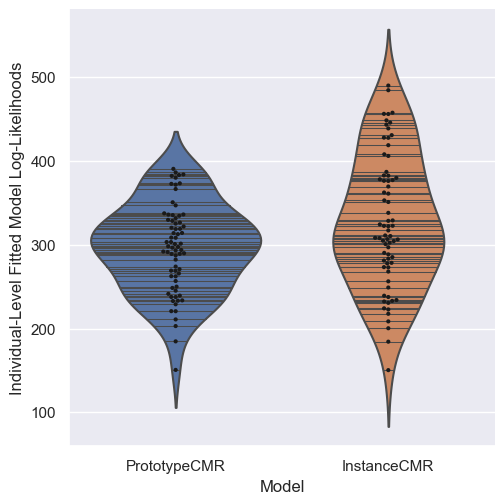

In [7]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects
plt.style.use('default')

individual_fits = [result.fun for result in cmr_results] + [result.fun for result in icmr_results]
labels = ['PrototypeCMR'] * len(cmr_results) + ['InstanceCMR'] * len(icmr_results)
individual_df = pd.DataFrame(individual_fits, index=labels, columns=['Fit']).reset_index()
individual_df.columns = ['Model', 'Fit']

sns.set(style="darkgrid")

g = sns.catplot(x='Model', y='Fit', data=individual_df, kind='violin', inner='stick')
sns.swarmplot(x="Model", y="Fit", color="k", size=3, data=individual_df, ax=g.ax)
g.ax.set_ylabel('Individual-Level Fitted Model Log-Likelihoods');
#plt.savefig('individual_murdock1970.pdf', bbox_inches="tight")

summary_table = pd.DataFrame(group.describe().rename(columns={'Fit':name}).squeeze()
            for name, group in individual_df.groupby('Model')).T.to_markdown()

In [8]:
#| output: false
print(summary_table)

|       |   InstanceCMR |   PrototypeCMR |
|:------|--------------:|---------------:|
| count |       72      |        72      |
| mean  |      327.197  |       295.883  |
| std   |       78.9126 |        52.6059 |
| min   |      150.454  |       150.732  |
| 25%   |      276.716  |       260.961  |
| 50%   |      314.061  |       297.756  |
| 75%   |      380.375  |       330.162  |
| max   |      489.85   |       390.498  |


::: {#fig-murdokafits layout-nrow=2 layout-valign="center"}

|       |   InstanceCMR with Novel Mechanism |   PrototypeCMR |
|:------|--------------:|---------------:|
| count |       72      |        72      |
| mean  |      327.197  |       295.883  |
| std   |       78.9126 |        52.6059 |
| min   |      150.454  |       150.732  |
| 25%   |      276.716  |       260.961  |
| 50%   |      314.061  |       297.756  |
| 75%   |      380.375  |       330.162  |
| max   |      489.85   |       390.498  |

Distribution of log-likelihood scores of recall sequences exhibited by each subject under each considered model across list-lengths [@murdock1970interresponse]
:::



As a follow-up, we also compared how readily each model could account for organizational summary statistics in the dataset. We found for each model variant the optimal parameter configuration maximizing the likelihood of the entire dataset rather than participant-by-participant. Using each fitted model variant, we simulated 1000 unique free recall trials and measured summary statistics from the result. [Figure @fig-MurdOkaSummary] plots for each model against the corresponding statistics collected over the dataset how recall probability varies as a function of serial position, how the probability of recalling an item first varies as a function of serial position, and how the conditional recall probabability of an item varies as a function of its serial lag from the previously recalled item. Recapitulating our comparison of log-likelihood distributions fitted over discrete participants, we found that both our prototype-based and instance-based CMR implementations account for these benchmark organizational summary statistics across the full dataset to similar extents. To build on this finding of broad model equivalence with respect to the results reported by @murdock1970interresponse, we consider the model variants under broader experimental conditions.

In [9]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset rather than participant-by-participant

cost_function = murdock_objective_function(
    List([murd_trials0]),  
    List([murd_length0]),
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
     'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True)

differential_evolution step 1: f(x)= 27977.7
differential_evolution step 2: f(x)= 27812.8
differential_evolution step 3: f(x)= 27812.8
differential_evolution step 4: f(x)= 26670.3
differential_evolution step 5: f(x)= 26670.3
differential_evolution step 6: f(x)= 26670.3
differential_evolution step 7: f(x)= 26670.3
differential_evolution step 8: f(x)= 26670.3
differential_evolution step 9: f(x)= 24698.1
differential_evolution step 10: f(x)= 24698.1
differential_evolution step 11: f(x)= 24698.1
differential_evolution step 12: f(x)= 23945.5
differential_evolution step 13: f(x)= 23945.5
differential_evolution step 14: f(x)= 23673.7
differential_evolution step 15: f(x)= 23663.3
differential_evolution step 16: f(x)= 23059.9
differential_evolution step 17: f(x)= 23059.9
differential_evolution step 18: f(x)= 23059.9
differential_evolution step 19: f(x)= 23059.9
differential_evolution step 20: f(x)= 23059.9
differential_evolution step 21: f(x)= 23059.9
differential_evolution step 22: f(x)= 23059

In [10]:
#| include: false
print(cmr_result)

     fun: 22728.601695613477
     jac: array([-3.31929185, 26.62782208, -0.07930794, -1.29875843, -2.43708199,
        1.85282261,  0.73450786,  0.        ,  3.87408363,  2.77250365,
       -2.20134099, 14.36492305])
 message: 'Optimization terminated successfully.'
    nfev: 8636
     nit: 36
 success: True
       x: array([5.74775717e-01, 2.80576505e-03, 7.30385891e-01, 3.65490947e-01,
       1.00000000e+00, 7.43839939e-02, 1.32167775e+01, 7.62554695e+01,
       3.13741166e-02, 3.36799238e-01, 5.16677510e+00, 9.96214830e-01])


In [11]:
#| output: false
#| code-summary: code -- 2) fit Instance_CMR to entire dataset rather than participant-by-participant

cost_function = murdock_objective_function(
    List([murd_trials0]),  
    List([murd_length0]),
    init_icmr,
    {'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    icmr_free_parameters)

icmr_result = differential_evolution(cost_function, icmr_bounds, disp=True)

differential_evolution step 1: f(x)= 27892.8
differential_evolution step 2: f(x)= 27892.8
differential_evolution step 3: f(x)= 27892.8
differential_evolution step 4: f(x)= 27643.6
differential_evolution step 5: f(x)= 27643.6
differential_evolution step 6: f(x)= 27643.6
differential_evolution step 7: f(x)= 27643.6
differential_evolution step 8: f(x)= 27643.6
differential_evolution step 9: f(x)= 27527.6
differential_evolution step 10: f(x)= 27527.6
differential_evolution step 11: f(x)= 27519.5
differential_evolution step 12: f(x)= 27515.5
differential_evolution step 13: f(x)= 27515.5
differential_evolution step 14: f(x)= 27515.5
differential_evolution step 15: f(x)= 27428.5
differential_evolution step 16: f(x)= 27428.5
differential_evolution step 17: f(x)= 27428.5
differential_evolution step 18: f(x)= 27428.5
differential_evolution step 19: f(x)= 27428.5
differential_evolution step 20: f(x)= 27428.5
differential_evolution step 21: f(x)= 27428.5
differential_evolution step 22: f(x)= 27428

In [12]:
#| include: false
print(icmr_result)

     fun: 22687.62345968608
     jac: array([ -2.2304448 ,   4.77521098,  -0.86729414,  -2.94057827,
       -15.73353067,   0.52896212,   0.02000888,   0.        ,
        14.51917342,  11.90601325,  -0.57916623, -13.61986499,
        -3.32656755])
 message: 'Optimization terminated successfully.'
    nfev: 12015
     nit: 24
 success: True
       x: array([6.49116610e-01, 4.45405447e-03, 7.68446980e-01, 7.63169921e-03,
       1.00000000e+00, 2.93379645e-01, 1.02770225e+01, 4.52131220e+01,
       3.13194288e-02, 3.37018745e-01, 1.86906517e+00, 9.97048917e-01,
       1.00000000e+01])


In [13]:
#| output: false
#| code-summary: code -- 3) compose simulated spc, lag-crp, pfr from overall fitting results

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
true_df = murd_events0.copy()

cmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['PrototypeCMR', 'data'])
cmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr = cmr_pfr.query('output <= 1')

fitted_parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
for i in range(len(icmr_result.x)):
    fitted_parameters[icmr_free_parameters[i]] = icmr_result.x[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['choice_sensitivity'] = 1
fitted_parameters['feature_sensitivity'] = 1

model = init_icmr(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)
icmr_spc = apply_and_concatenate(fr.spc, sim_df, true_df, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp = apply_and_concatenate(fr.lag_crp, sim_df, true_df, 'source', ['InstanceCMR', 'data'])
icmr_pfr = apply_and_concatenate(fr.pnr, sim_df, true_df, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr = icmr_pfr.query('output <= 1')

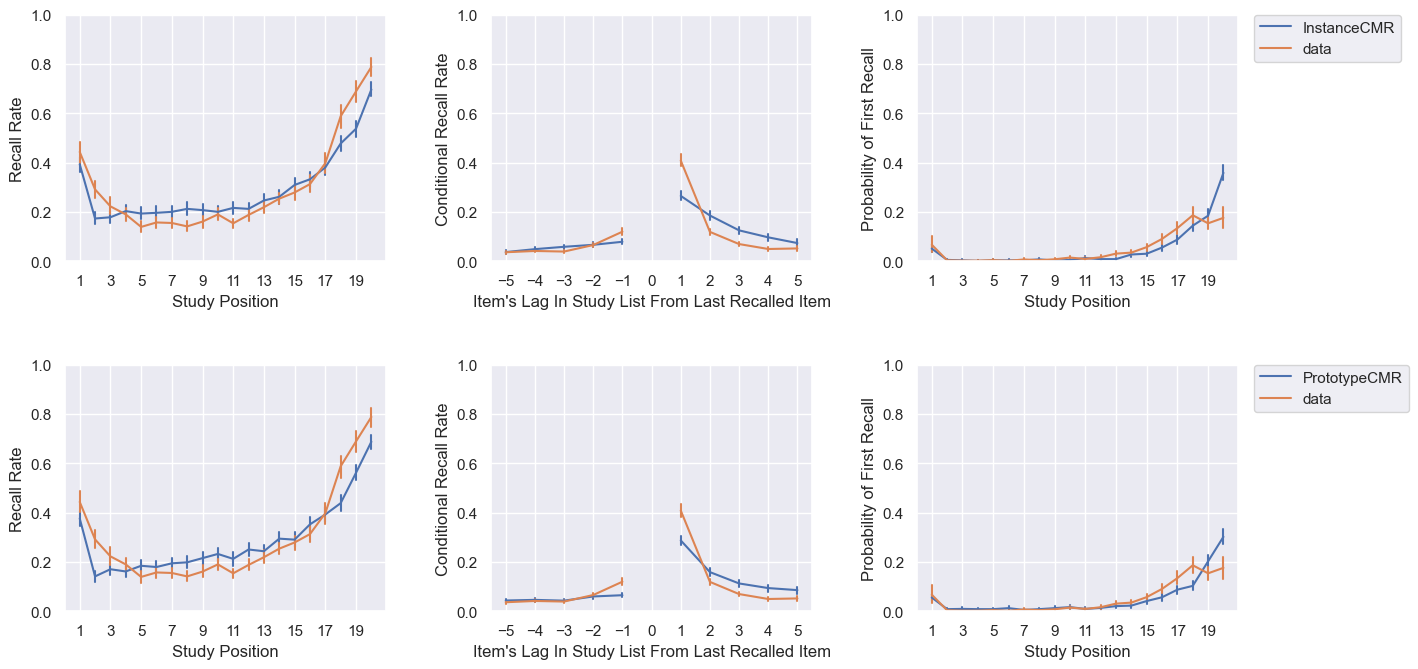

In [14]:
#| code-summary: code -- 4) plot each summary statistic corresponding to each configured model

import matplotlib.pyplot as plt

sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15/2), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0, 0], data=icmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 0].set_xticks(np.arange(1, 21, 2))
axes[0, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 0], data=cmr_spc, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[1, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[1, 0].set_xticks(np.arange(1, 21, 2))
axes[1, 0].set_ylim((0, 1))

# lag crp curve
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[0, 1], data=icmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[0, 1], data=icmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[0, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[0, 1].set_xticks(np.arange(-5, 6, 1))
axes[0, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 1].set(xlabel='Item\'s Lag In Study List From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 1].set_xticks(np.arange(-5, 6, 1))
axes[1, 1].set_ylim((0, 1))

# pfr
sns.lineplot(data=icmr_pfr, x='input', y='prob', err_style='bars', ax=axes[0, 2], hue='source')
axes[0, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[0, 2].set_xticks(np.arange(1, 21, 2))
axes[0, 2].set_ylim((0, 1))

sns.lineplot(data=cmr_pfr, x='input', y='prob', err_style='bars', ax=axes[1, 2], hue='source')
axes[1, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[1, 2].set_xticks(np.arange(1, 21, 2))
axes[1, 2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout(pad=3)
plt.savefig('overall_murdock1970.pdf', bbox_inches='tight')

![Comparison of summary statistics between each model against observed data [@murdock1970interresponse]](overall_murdock1970.pdf){#fig-murdokasummary}